In [1]:
import os
import pickle
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

### Initial Exploration of data

In [2]:
train_file_path = os.path.expanduser('~/data/train.pickle')
with open(train_file_path, 'rb') as file:
    train_data = pickle.load(file)

test_file_path = os.path.expanduser('~/data/test_kaggle.pickle')
with open(test_file_path, 'rb') as file:
    test_data = pickle.load(file)

In [3]:
df_train = pd.DataFrame(train_data)
df_train.head()

,price,title,loc_string,loc,features,type,subtype,selltype,desc
0,320.000 €,Piso Tallers. Piso con 2 habitaciones con asce...,Barcelona - Sant Antoni,None,"[85 m2, 2 hab., 1 baño, 3.647 €/m2]",FLAT,FLAT,SECOND_HAND,Piso en última planta a reformar en calle Tall...
1,335.000 €,Piso C/ de valència. Piso reformado en venta d...,Barcelona - Dreta de l´Eixample,None,"[65 m2, 2 hab., 1 baño, 5.000 €/m2]",FLAT,FLAT,SECOND_HAND,"Ubicado en la zona del Camp de l’Arpa, cerca d..."
2,330.000 €,Piso en Dreta de l´Eixample. Acogedor piso al ...,Barcelona - Dreta de l´Eixample,None,"[77 m2, 2 hab., 1 baño, 4.286 €/m2]",FLAT,FLAT,SECOND_HAND,"En pleno centro de Barcelona, justo al lado de..."
3,435.000 €,"Piso Barcelona - corts catalanes. Soleado, cén...",Barcelona - Sant Antoni,None,"[96 m2, 3 hab., 2 baños, 4.531 €/m2]",FLAT,FLAT,SECOND_HAND,"Vivienda espaciosa en Sant Antoni, cerca de Pl..."
4,410.000 €,"Piso en Carrer de sardenya 271. Alto, reformad...",Barcelona - Sagrada Família,Carrer de Sardenya 271,"[84 m2, 2 hab., 1 baño, 4.881 €/m2]",FLAT,FLAT,SECOND_HAND,"En el corazón de Barcelona, en una hermosa fin..."


In [4]:
df_train['type'].value_counts()

FLAT            806
APARTMENT        19
PENTHOUSE        14
DUPLEX           11
GROUND_FLOOR      7
STUDIO            6
LOFT              3
Name: type, dtype: int64

In [5]:
df_train['subtype'].value_counts()

FLAT            806
APARTMENT        19
PENTHOUSE        14
DUPLEX           11
GROUND_FLOOR      7
STUDIO            6
LOFT              3
Name: subtype, dtype: int64

In [6]:
(df_train['subtype'] != df_train['type']).sum()

0

Type and subtype consist of the same values. We can drop one column. 

In [7]:
df_train['selltype'].value_counts()

SECOND_HAND    866
Name: selltype, dtype: int64

No variation, can remove. 

In [8]:
df_train['loc'].value_counts()

Carrer de Viladomat 297                2
Carrer de Provença 355                 2
Gran Via de les Corts Catalanes 548    2
Carrer del Consell de Cent 131         2
Carrer Taulat 42                       1
                                      ..
Carrer de Viladomat 81                 1
Carrer de la Marina 212                1
VALENCIA 539                           1
Carrer del Rosselló                    1
Plaça Ferran Reyes s/n                 1
Name: loc, Length: 88, dtype: int64

In [9]:
df_train['loc_string'].value_counts()

Barcelona - Sagrada Família                                 163
Barcelona - Poblenou                                        111
Barcelona - La Nova Esquerra de l´Eixample                  100
Barcelona - Sant Antoni                                      94
Barcelona - El Parc i la Llacuna del Poblenou                88
Barcelona - Dreta de l´Eixample                              77
Barcelona - L´Antiga Esquerra de l´Eixample                  74
Barcelona - Navas                                            57
Barcelona - Fort Pienc                                       53
Barcelona - La Vila Olímpica del Poblenou                    19
Barcelona - El Camp de l´Arpa del Clot                       18
Barcelona - Provençals del Poblenou                           3
Barcelona - La Nova Esquerra de l´Eixample\nVer mapa          2
Barcelona - Poblenou\nVer mapa                                2
Barcelona - El Clot                                           2
Barcelona - Dreta de l´Eixample\nVer map

##### Ideas for cleaning: 
* price -> integer (only for train data)
* loc_string -> one-hot encode (neighboorhoods)
* loc -> use? doesn't seem useful -> maybe try it out
* Features -> need to create more columns -> m2, bedrooms, bathrooms
    - drop price_per_m2 b/c not in test data
* Type and SubType the same, delete one of them
* All selltypes secondhand, can delete
* Title -> word embeddings?
* Description -> word embeddings? 

### Clean data

In [10]:
def get_new_bedroom(fea):
    """If no bedroom, insert bedroom as 0."""
    return [fea[0], "0 hab.", fea[1], fea[-1]]

def get_new_bathroom(fea):
    """If no bathroom, insert bedroom as 0."""
    return [fea[0], fea[1], "0 baño", fea[-1]]

def clean_features(data):
    """Make sure all features are consistent with the format
    [m2, bedroom, bathroom, price/m2]"""
    cleaned_data = []
    for i, d in enumerate(data):
        features = d["features"]
        # If no bedroom, insert bedroom as 0
        if not bool(re.match("\d hab", features[1])):
            if len(features) < 4:
                features = get_new_bedroom(features)
                d["features"] = features
        features = d["features"]
        # If no bathroom, insert bedroom as 0
        if not bool(re.match("\d baño", features[2])):
            features = get_new_bathroom(features)
            d["features"] = features
        cleaned_data.append(d)
    return cleaned_data

In [11]:
def clean_data(data, train=False):
    """Clean data to prepare for modeling
    
    Args: 
    - data: original data from pickle file
    - train (bool): indicator of training/test set
    
    Returns:
    - df: cleaned df ready for model
    """
    # Clean feature column
    clean_data = clean_features(data)

    # Convert to df
    df = pd.DataFrame(clean_data)

    # Create columns m^2, bedrooms, bathrooms from features
    df['m2'] = df['features'].apply(lambda x: int(x[0].split()[0]))
    df['bedrooms'] = df['features'].apply(lambda x: float(x[1].split()[0]))
    df['bathrooms'] = df['features'].apply(lambda x: float(x[2].split()[0]))

    # Drop columns with repetitive data or no variation
    df = df.drop(['subtype', 'selltype', 'features'], axis=1)

    # Turn price into integer column -> only needed for training set
    if train is True:
        df['price'] = df['price'].apply(lambda x: int(x.replace(".", "").split()[0]))
    
    return df


In [12]:
train_df = clean_data(train_data, train=True)
test_df = clean_data(test_data, train=False)

In [13]:
train_df.head()

,price,title,loc_string,loc,type,desc,m2,bedrooms,bathrooms
0,320000,Piso Tallers. Piso con 2 habitaciones con asce...,Barcelona - Sant Antoni,None,FLAT,Piso en última planta a reformar en calle Tall...,85,2.0,1.0
1,335000,Piso C/ de valència. Piso reformado en venta d...,Barcelona - Dreta de l´Eixample,None,FLAT,"Ubicado en la zona del Camp de l’Arpa, cerca d...",65,2.0,1.0
2,330000,Piso en Dreta de l´Eixample. Acogedor piso al ...,Barcelona - Dreta de l´Eixample,None,FLAT,"En pleno centro de Barcelona, justo al lado de...",77,2.0,1.0
3,435000,"Piso Barcelona - corts catalanes. Soleado, cén...",Barcelona - Sant Antoni,None,FLAT,"Vivienda espaciosa en Sant Antoni, cerca de Pl...",96,3.0,2.0
4,410000,"Piso en Carrer de sardenya 271. Alto, reformad...",Barcelona - Sagrada Família,Carrer de Sardenya 271,FLAT,"En el corazón de Barcelona, en una hermosa fin...",84,2.0,1.0


### TFIDF Vectorization: 

In [14]:
def clean_text(text):
    """Clean text to prepare for TFIDF Vectorization"""
    # Remove newline characters
    text = re.sub(r'\n', ' ', text)
    # Remove backslash and the character following it
    text = re.sub(r'\\.', '', text)
    # Remove other special characters (customize as needed)
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word.lower() not in stopword_es])
    return text


In [15]:
# Get Spanish stopwords
nltk.download('stopwords')
stopword_es = nltk.corpus.stopwords.words('spanish')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/swaterman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def tfidf_vectorize(df_train, df_test, col):
    cleaned_col = f'{col}_cleaned'
    vectorized_col = f'{col}_vector'
    
    # Apply the cleaning function to both train and test data
    df_train[cleaned_col] = df_train[col].apply(clean_text)
    df_test[cleaned_col] = df_test[col].apply(clean_text)

    # Fit vectorizer to training data and vectorize
    vectorizer = TfidfVectorizer()
    train_corpus = df_train[cleaned_col].values
    train_vectorized = vectorizer.fit_transform(train_corpus)

    # Vectorizer test data
    test_corpus = df_test[cleaned_col].values
    test_vectorized = vectorizer.transform(test_corpus)

    df_train[vectorized_col] = list(train_vectorized.toarray())
    df_test[vectorized_col] = list(test_vectorized.toarray())

### Normalize data

In [17]:
def normalize_numerical_col(df_train, df_val, df_test, col):
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on train col
    scaler.fit(df_train[[col]])

    # Scale the column on train/val/test 
    normalized_col = f'norm_{col}'
    df_train[normalized_col] = scaler.transform(df_train[[col]])
    df_val[normalized_col] = scaler.transform(df_val[[col]])
    df_test[normalized_col] = scaler.transform(df_test[[col]])

    # Drop original col from df
    df_train.drop(col, axis=1, inplace=True)
    df_val.drop(col, axis=1, inplace=True)
    df_test.drop(col, axis=1, inplace=True)
    

### Encode Data

In [19]:
def one_hot_encoder(df_train, df_val,  df_test, col):
    """One-hot encodes columns."""
    
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    # Fit the encoder on the training set
    encoder.fit(df_train[[col]])

    # Encode train/val/test 
    train_encoded = encoder.transform(df_train[[col]])
    val_encoded = encoder.transform(df_val[[col]])
    test_encoded = encoder.transform(df_test[[col]])

    # Convert arrays back to df and concatenate with original df
    df_train = pd.concat([df_train.drop(columns=[col]), pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out())], axis=1)
    df_val = pd.concat([df_val.drop(columns=[col]), pd.DataFrame(val_encoded, columns=encoder.get_feature_names_out())], axis=1)
    df_test = pd.concat([df_test.drop(columns=[col]), pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out())], axis=1)

    return df_train, df_val, df_test

In [20]:
def label_encoder(train_df, val_df, test_df, col):
    """Label encodes columns with handling for unseen data as 'unknown'."""

    encoded_col = f'{col}_encoded'
    # Add 'unknown' placeholder label
    train_labels = train_df[col].unique().tolist()
    train_labels.append('unknown')  

    # Replace unseen labels in the test and val set with 'unknown'
    val_df[col] = val_df[col].apply(lambda x: x if x in train_labels else 'unknown')
    test_df[col] = test_df[col].apply(lambda x: x if x in train_labels else 'unknown')

    label_encoder = LabelEncoder()
    label_encoder.fit(train_labels)
    
    # Encode train/val/test 
    train_df[encoded_col] = label_encoder.transform(train_df[col])
    val_df[encoded_col] = label_encoder.transform(val_df[col])
    test_df[encoded_col] = label_encoder.transform(test_df[col])

    # Drop original col from df
    train_df.drop(col, axis=1, inplace=True)
    val_df.drop(col, axis=1, inplace=True)
    test_df.drop(col, axis=1, inplace=True)

    return train_df, val_df, test_df

# Initial Data Visualization

### Distribution of data

In [31]:
train_df['price'].mean()

343885.8648960739

In [33]:
train_df['bedrooms'].mean()

2.720554272517321

In [34]:
train_df['bathrooms'].mean()

1.420323325635104

In [36]:
train_df['m2'].mean()

80.60161662817552

In [37]:
len(df_train)

866

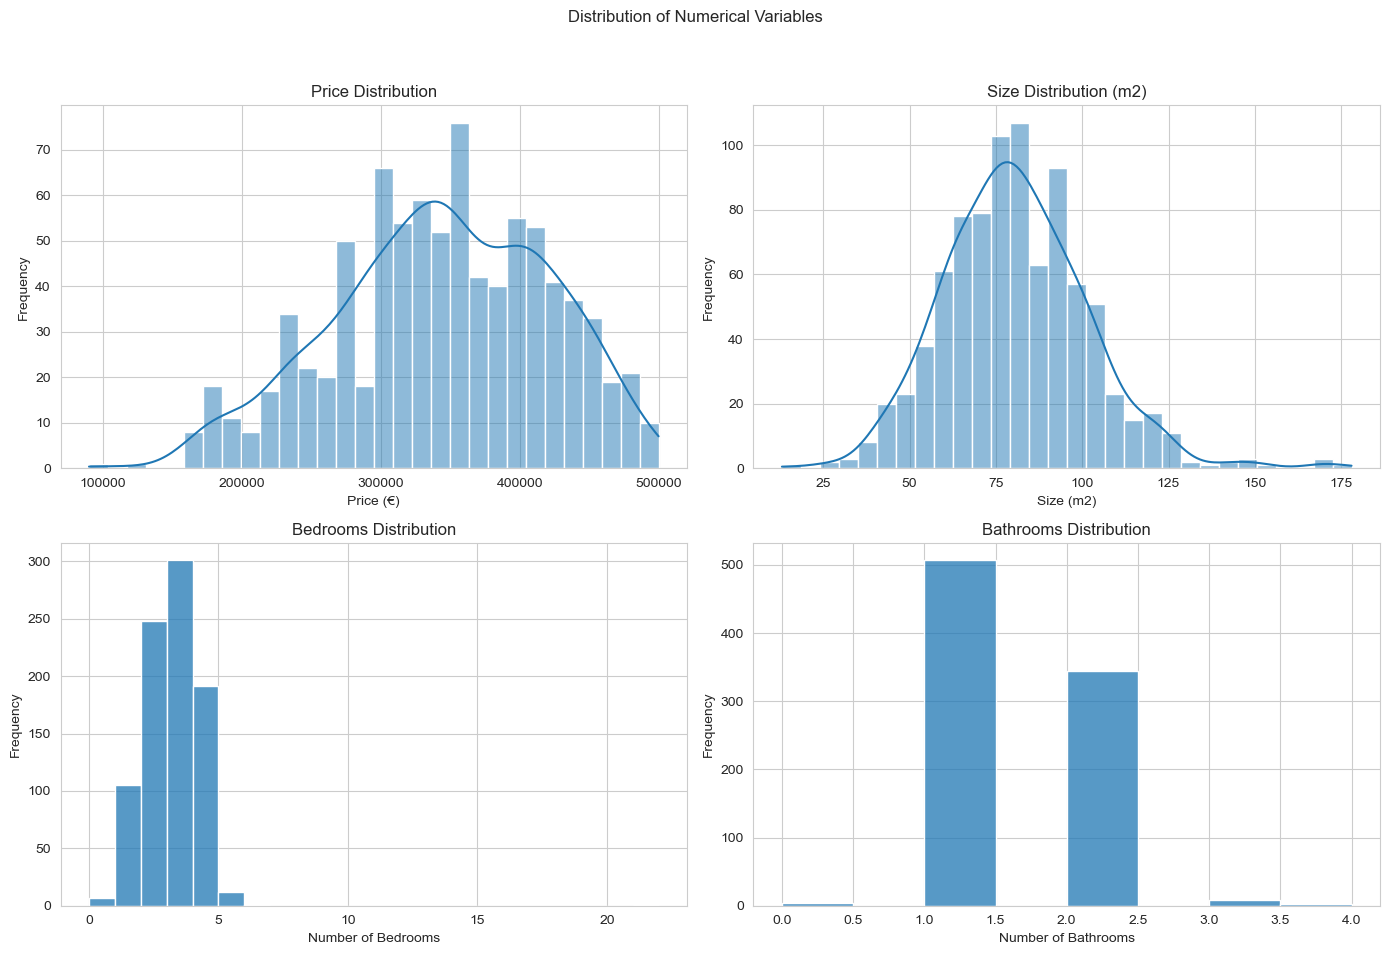

In [21]:
sns.set_style("whitegrid")

# Prepare figure layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of Numerical Variables')

# Price
sns.histplot(train_df['price'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Price Distribution')
axes[0, 0].set_xlabel('Price (€)')
axes[0, 0].set_ylabel('Frequency')

# Size - m^2
sns.histplot(train_df['m2'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Size Distribution (m2)')
axes[0, 1].set_xlabel('Size (m2)')
axes[0, 1].set_ylabel('Frequency')

# Bedrooms
sns.histplot(train_df['bedrooms'].dropna(), bins=int(train_df['bedrooms'].max()), kde=False, ax=axes[1, 0])
axes[1, 0].set_title('Bedrooms Distribution')
axes[1, 0].set_xlabel('Number of Bedrooms')
axes[1, 0].set_ylabel('Frequency')

# Bathrooms
sns.histplot(train_df['bathrooms'].dropna(), bins=int(train_df['bathrooms'].max()*2), kde=False, ax=axes[1, 1])
axes[1, 1].set_title('Bathrooms Distribution')
axes[1, 1].set_xlabel('Number of Bathrooms')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


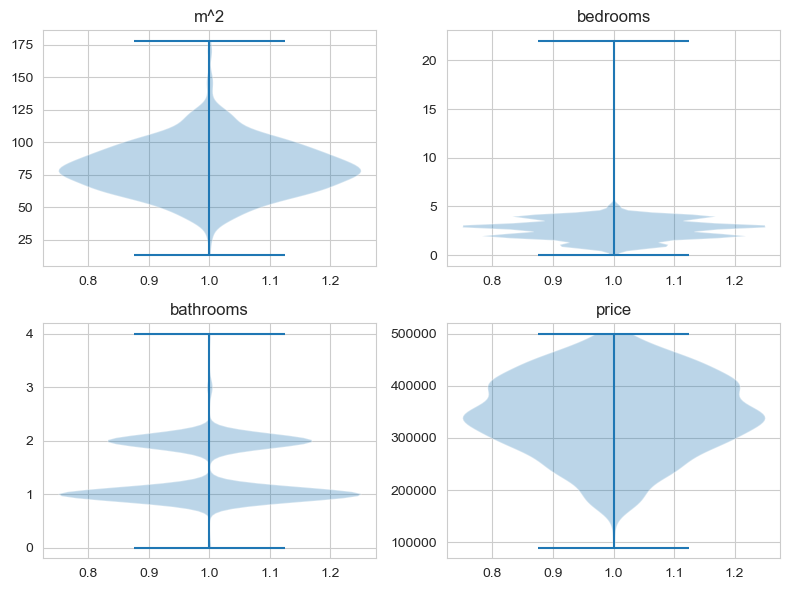

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,6))  
axes = axes.flatten()

axes[0].set_title('m^2')
axes[0].violinplot(train_df['m2'])

axes[1].set_title('bedrooms')
axes[1].violinplot(train_df['bedrooms'])

axes[2].set_title('bathrooms')
axes[2].violinplot(train_df['bathrooms'])

axes[3].set_title('price')
axes[3].violinplot(train_df['price'])

plt.tight_layout()
plt.show()

#### Outliers? Should we remove the bedrooms outlier?

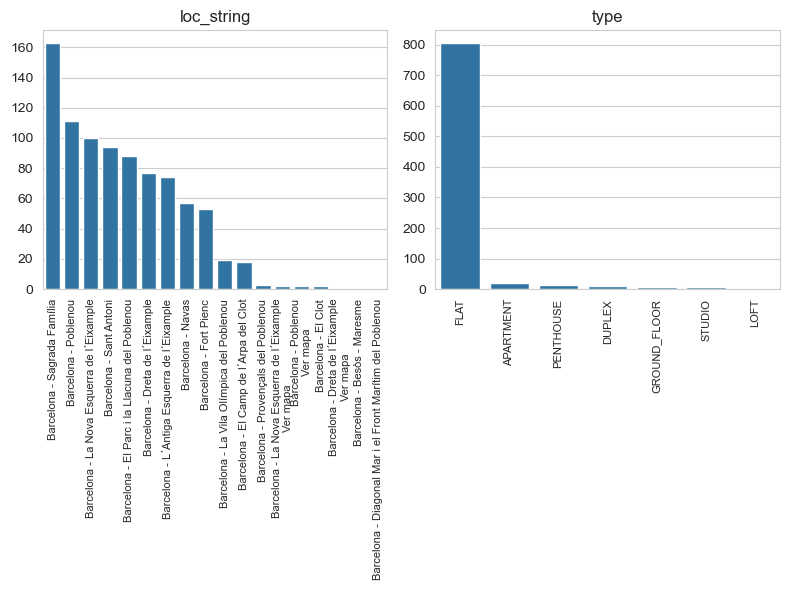

In [23]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

loc_string_counts = train_df['loc_string'].value_counts()
type_counts = train_df['type'].value_counts()

# loc_string
sns.barplot(x=loc_string_counts.index, y=loc_string_counts.values, ax=axes[0], color='tab:blue')
axes[0].set_title('loc_string')
axes[0].tick_params(axis='x', labelsize=8)
axes[0].tick_params(axis='x', rotation=90)

# type
sns.barplot(x=type_counts.index, y=type_counts.values, ax=axes[1], color='tab:blue')
axes[1].set_title('type')
axes[1].tick_params(axis='x', labelsize=8)
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


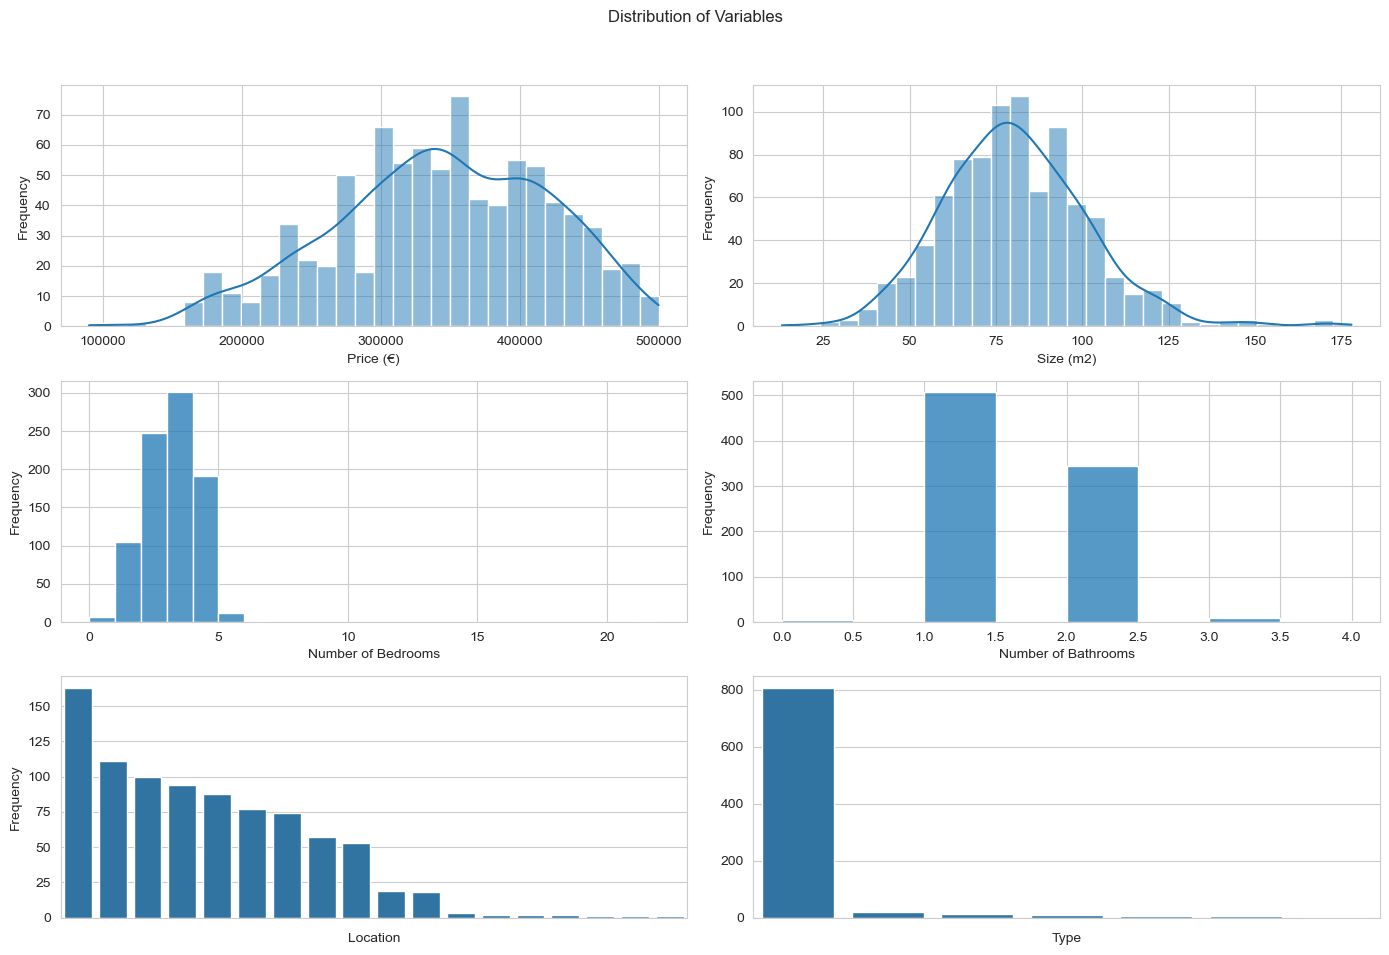

In [39]:
sns.set_style("whitegrid")

# Prepare figure layout
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Distribution of Variables')

# Price
sns.histplot(train_df['price'], bins=30, kde=True, ax=axes[0, 0])
#axes[0, 0].set_title('Price Distribution')
axes[0, 0].set_xlabel('Price (€)')
axes[0, 0].set_ylabel('Frequency')

# Size - m^2
sns.histplot(train_df['m2'], bins=30, kde=True, ax=axes[0, 1])
#axes[0, 1].set_title('Size Distribution (m2)')
axes[0, 1].set_xlabel('Size (m2)')
axes[0, 1].set_ylabel('Frequency')

# Bedrooms
sns.histplot(train_df['bedrooms'].dropna(), bins=int(train_df['bedrooms'].max()), kde=False, ax=axes[1, 0])
#axes[1, 0].set_title('Bedrooms Distribution')
axes[1, 0].set_xlabel('Number of Bedrooms')
axes[1, 0].set_ylabel('Frequency')

# Bathrooms
sns.histplot(train_df['bathrooms'].dropna(), bins=int(train_df['bathrooms'].max()*2), kde=False, ax=axes[1, 1])
#axes[1, 1].set_title('Bathrooms Distribution')
axes[1, 1].set_xlabel('Number of Bathrooms')
axes[1, 1].set_ylabel('Frequency')

sns.barplot(x=loc_string_counts.index, y=loc_string_counts.values, ax=axes[2, 0], color='tab:blue')
#axes[2, 0].set_title('Location Distribution')
axes[2, 0].tick_params(axis='x', labelsize=8)
axes[2, 0].tick_params(axis='x', rotation=45)
axes[2, 0].set_xlabel('Location')  # Remove x-axis label
axes[2, 0].set_xticklabels([])  # Hide x-axis tick labels
axes[2, 0].set_ylabel('Frequency')

# type
sns.barplot(x=type_counts.index, y=type_counts.values, ax=axes[2, 1], color='tab:blue')
#axes[2, 1].set_title('Type Distribution')
axes[2, 1].tick_params(axis='x', labelsize=8)
axes[2, 1].tick_params(axis='x', rotation=45)
axes[2, 1].set_xlabel('Type')  # Remove x-axis label
axes[2, 1].set_xticklabels([])  # Hide x-axis tick labels

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Data relative to price

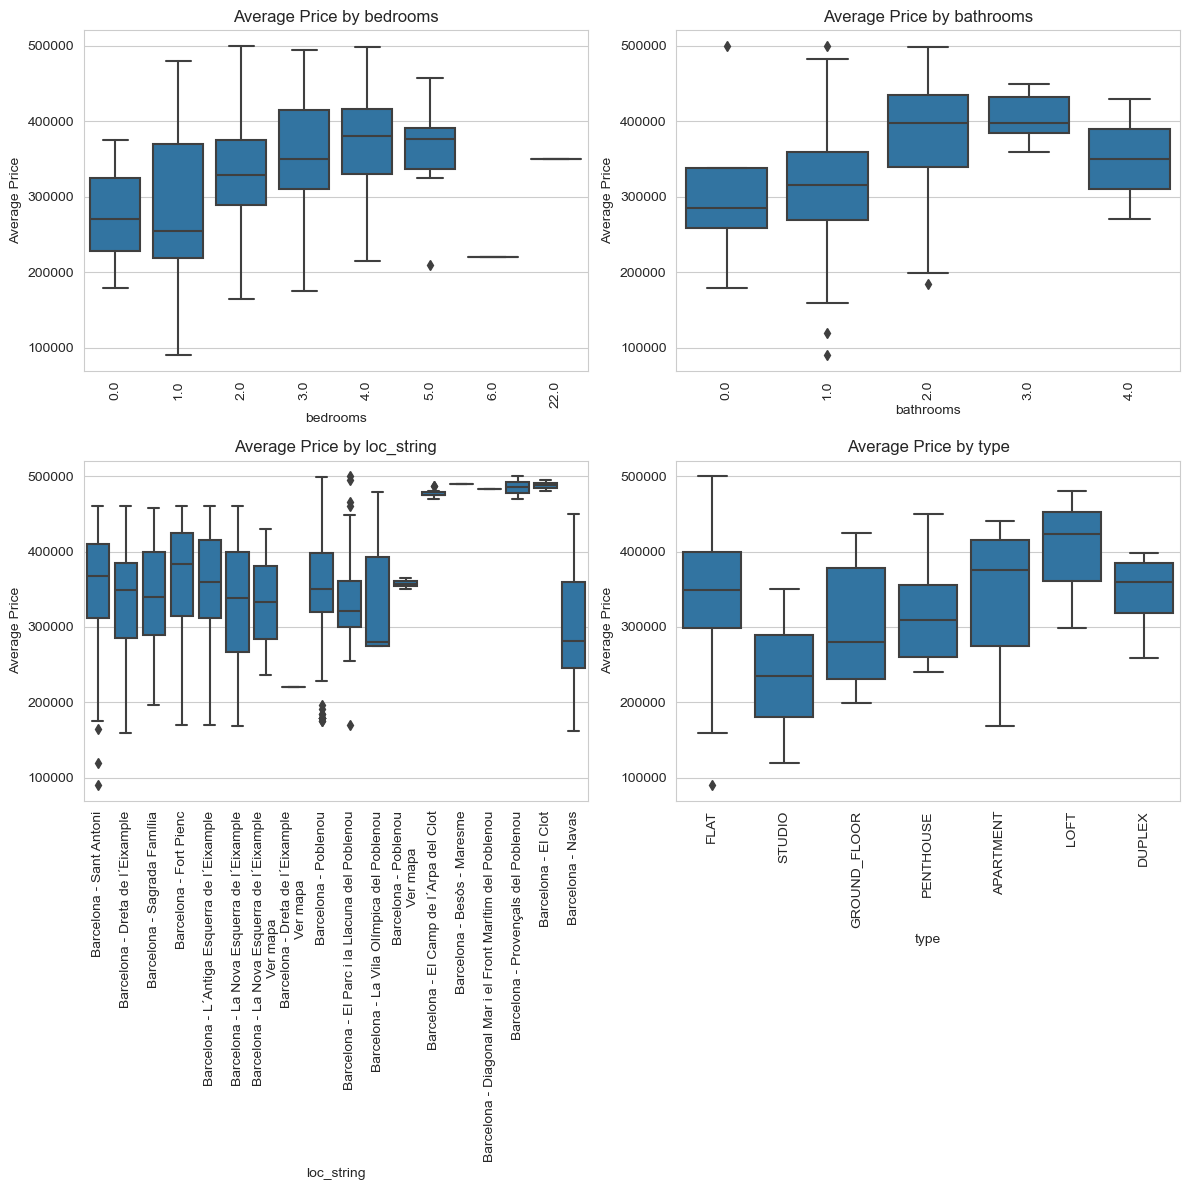

In [49]:
def plot_col_price_grid(train_df, cols):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    boxplot_color = "tab:blue"

    for i, col in enumerate(cols):
        sns.boxplot(ax=axes[i], x=col, y='price', data=train_df, color=boxplot_color)
        axes[i].set_title(f'Average Price by {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Average Price')
        axes[i].tick_params(axis='x', rotation=90)
        
    plt.tight_layout()
    plt.show()


columns = ['bedrooms', 'bathrooms', 'loc_string', 'type']
plot_col_price_grid(train_df, columns)


In [23]:
def plot_col_price(train_df, col):
    # Plotting
    plt.figure(figsize=(12, 6))  
    sns.boxplot(x=col, y='price', data=train_df)

    plt.title(f'Box plot of Average Price by {col}') 
    plt.xlabel(col)  
    plt.ylabel('Average Price') 
    plt.xticks(rotation=90) 

    plt.show()

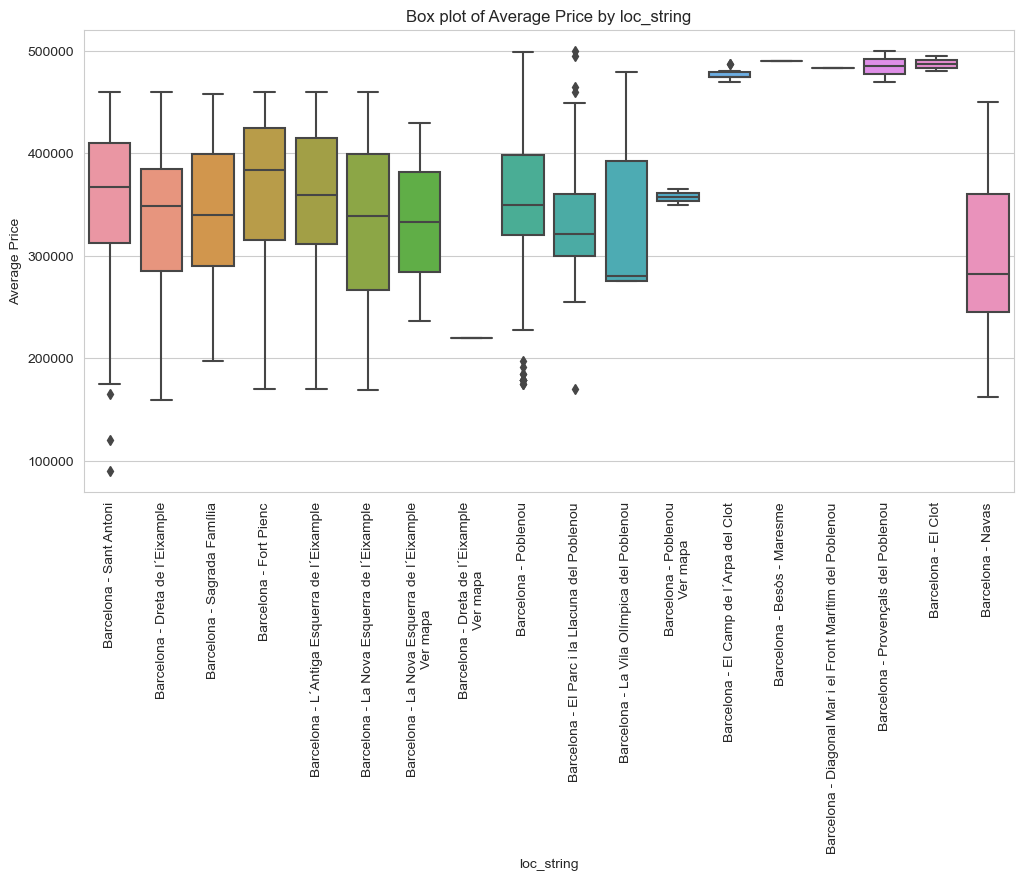

In [24]:
plot_col_price(train_df, col='loc_string')

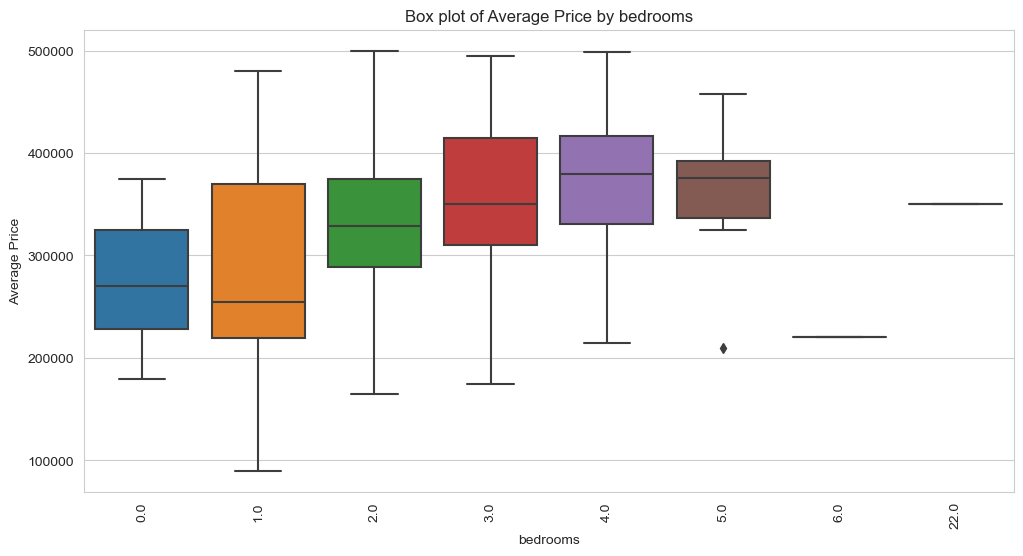

In [25]:
plot_col_price(train_df, col='bedrooms')

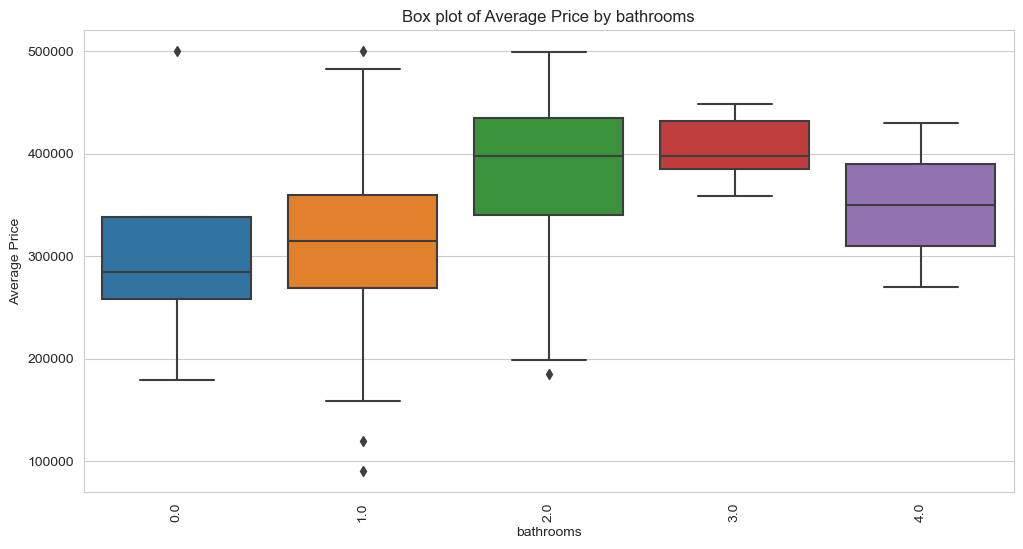

In [26]:
plot_col_price(train_df, col='bathrooms')

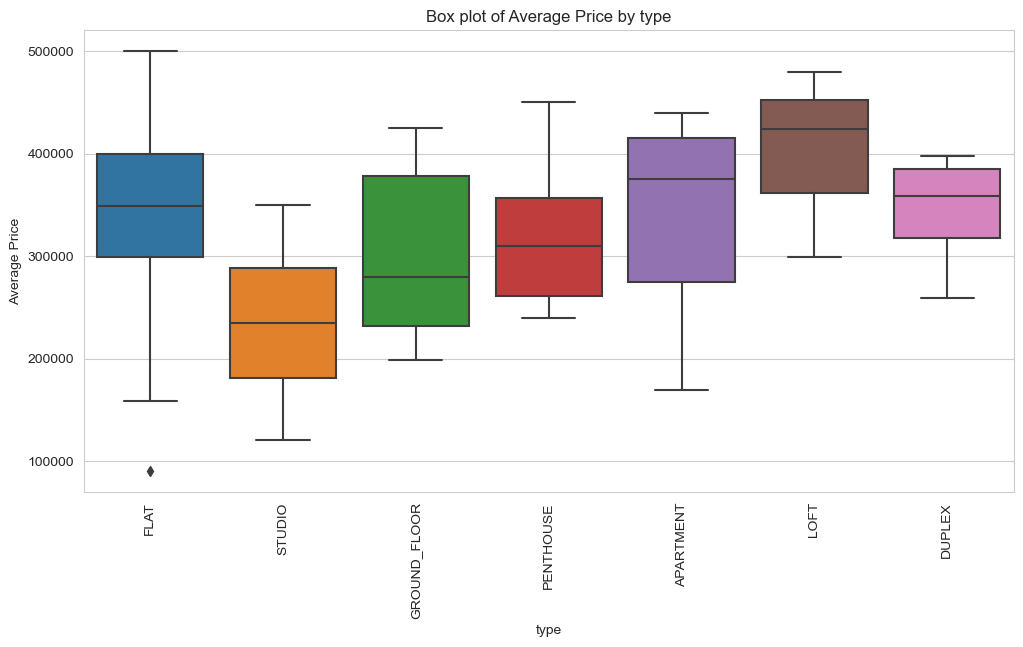

In [27]:
plot_col_price(train_df, col='type')

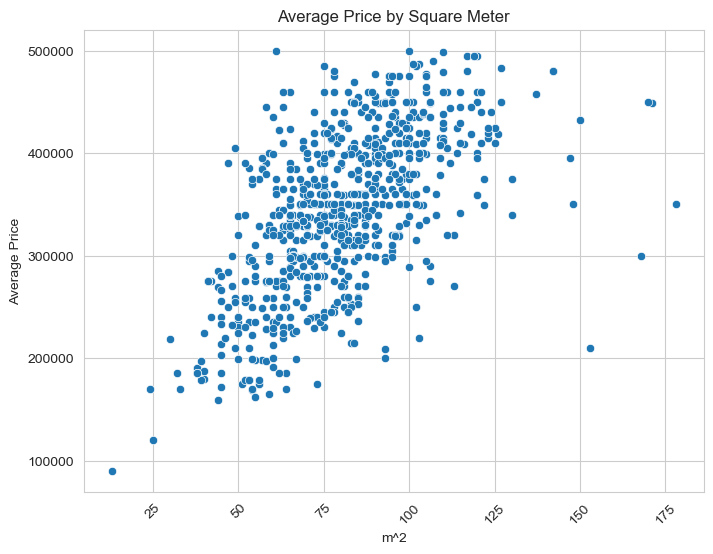

In [51]:
plt.figure(figsize=(8, 6)) 
sns.scatterplot(x='m2', y='price', data=train_df)

plt.title('Average Price by Square Meter') 
plt.xlabel('m^2')
plt.ylabel('Average Price') 
plt.xticks(rotation=45)  

plt.show()